Importing the Necessary Libraries 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.metrics import classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
import evaluate

Logging to Hugging Face to puch the finetuned model there

In [1]:
from huggingface_hub import notebook_login
notebook_login()

Setting up device-agnostic code

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


Showing the GPU Status 

In [15]:
!nvidia-smi

Wed Jul 31 15:23:34 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 552.22                 Driver Version: 552.22         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650 Ti   WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   48C    P8              2W /   50W |    3873MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
dataset = load_dataset("gnad10")

# Loading and Printing the dataset
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 9245
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1028
    })
})


In [36]:
# Display first 10 rows of the train set
print(dataset['train'].to_pandas().head(10))

                                                text  label
0  21-Jähriger fällt wohl bis Saisonende aus. Wie...      4
1  Erfundene Bilder zu Filmen, die als verloren g...      8
2  Der frischgekürte CEO Sundar Pichai setzt auf ...      0
3  Putin: "Einigung, dass wir Menge auf Niveau vo...      3
4  Estland sieht den künftigen österreichischen P...      5
5  Der Welser Stempelhersteller verbreitert sich ...      3
6  Traditionsklub setzt sich gegen den FC Utrecht...      4
7  Finanzausschuss tagte Montag: Konfliktthemen S...      6
8  Militär setzt Offensive an Grenze zu Afghanist...      2
9  Abschiedstournee für Guardiola beginnt beim HS...      4


In [38]:
# Display first 10 rows of the test set
print(dataset['test'].to_pandas().head(10))

                                                text  label
0  Die Gewerkschaft GPA-djp lanciert den "All-in-...      3
1  Franzosen verteidigen 2:1-Führung – Kritische ...      4
2  Neues Video von Designern macht im Netz die Ru...      0
3  23-jähriger Brasilianer muss vier Spiele pausi...      4
4  Aufständische verwendeten Chemikalie bei Gefec...      2
5  Bewährungs- und Geldstrafe für 26-Jährigen weg...      0
6  ÖFB-Teamspieler nur sechs Minuten nach seinem ...      4
7  Ein 31-jähriger Polizist soll einer 42-Jährige...      1
8  18 Menschen verschleppt. Kabul – Nach einem Hu...      2
9  Deutschland und Frankreich am stärksten von Lo...      0


Label names: ['Web', 'Panorama', 'International', 'Wirtschaft', 'Sport', 'Inland', 'Etat', 'Wissenschaft', 'Kultur']


C:\Users\swapn\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


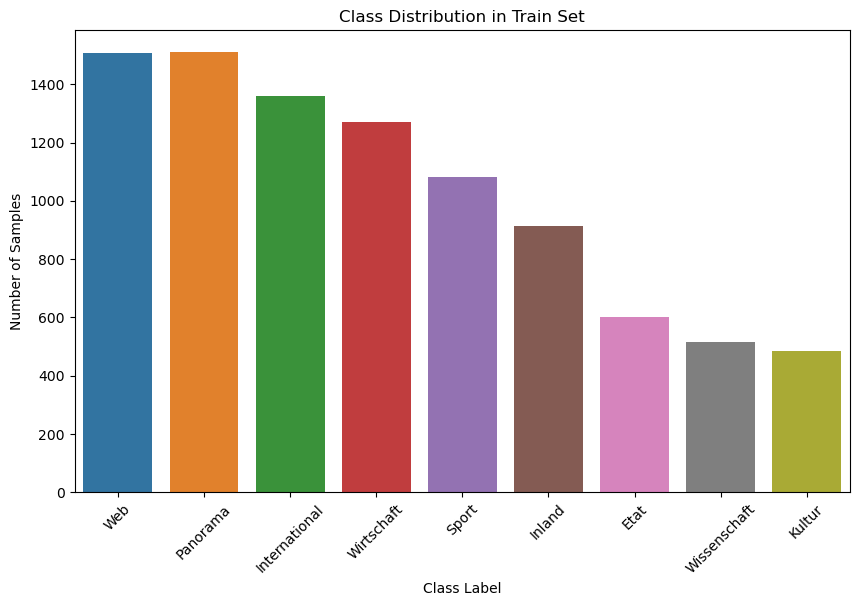

C:\Users\swapn\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


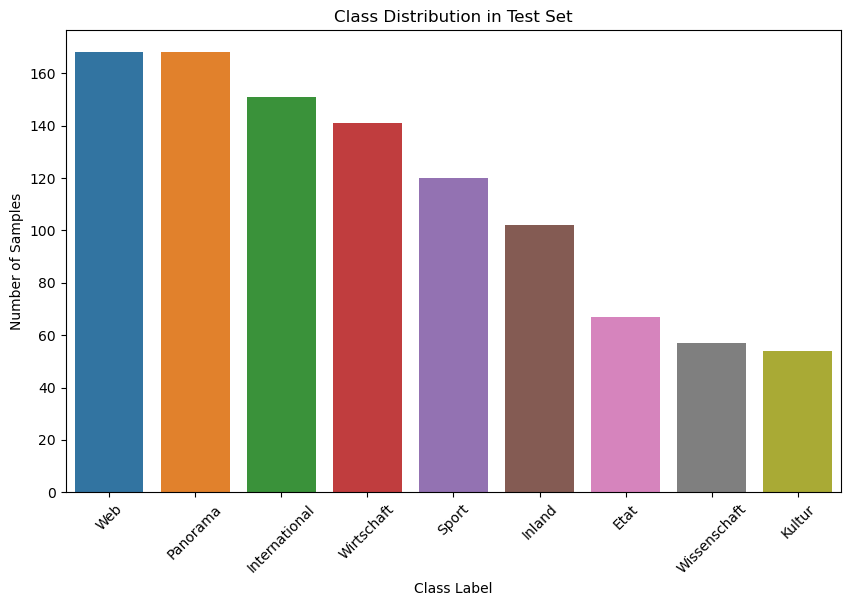

In [19]:
label_names = dataset["train"].features["label"].names

print(f"Label names: {label_names}")

# Visualizing Training and Testing Class Distribution
for split in ["train", "test"]:
    label_counts = dataset[split]["label"]
    plt.figure(figsize=(10, 6))
    sns.countplot(x=label_counts)
    plt.title(f"Class Distribution in {split.capitalize()} Set")
    plt.xlabel("Class Label")
    plt.ylabel("Number of Samples")
    plt.xticks(range(len(label_names)), label_names, rotation=45)
    plt.show()

We can see that classes are not balanced. That means the dataset is slightly imbalanced. We can celeraly see that the first 3 classes have more number of samples than the other classes. So model will be more accurate towards the more sample classes and less towards the low sample classes.

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\swapn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\swapn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


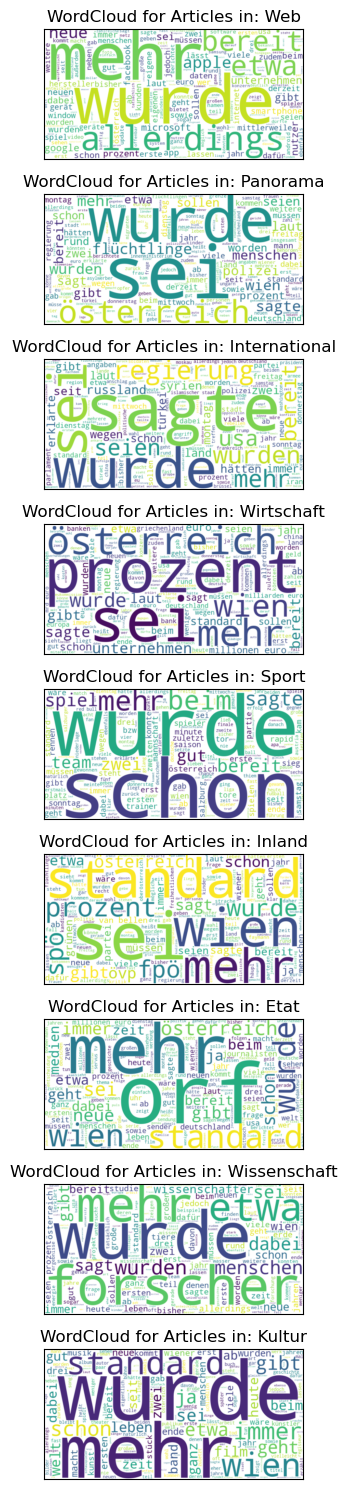

In [6]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from itertools import chain
import nltk

# Downloading NLTK data 
nltk.download('punkt')
nltk.download('stopwords')

# German stopwords
german_stopwords = set(stopwords.words('german'))

# Preprocessing function
def preprocess(text):
    text = text.lower()  # Lowercasing
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text_list = word_tokenize(text, language='german')  # Tokenize
    text_list = [word for word in text_list if word not in german_stopwords]  # Remove stopwords
    return text_list

# Applying preprocessing to the 'text' column

preprocessed_text = dataset['train']['text']
preprocessed_text = [preprocess(text) for text in preprocessed_text]

# Converting to DataFrame for easier handling 

classification_df = pd.DataFrame({'text': preprocessed_text, 'label': dataset['train']['label']})

# Get the unique labels and their count

unique_labels = dataset['train'].features['label'].names
n_labels = len(unique_labels)

# Setting up the plot grid

fig, axes = plt.subplots(n_labels, 1, figsize=(15, 15)) 

# Generate word cloud for each label

for i, label in enumerate(unique_labels):
    # Get all preprocessed text for the current label
    
    current_label_text = classification_df['text'][articles_df['label'] == i]
    text = ' '.join(list(chain(*current_label_text)))

    # Generating word cloud
    
    wordcloud = WordCloud(background_color="white", width=800, height=400).generate(text)

    # Displaying the word cloud
    
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)
    axes[i].set_title(f"WordCloud for Articles in: {label}")


plt.tight_layout()
plt.show()

In this code cell I have performed WordCloud visualization to see which words are the most frequent accure in each class. Also did the preprossing here to elimanating the noise to get a more meaningful visualization. In that I remove the punctuation and stopwords and lowercasing it.

In [ ]:
class GermanNewsClassifier:
    def __init__(self):
        # Loading Dataset
        self.dataset = load_dataset("gnad10")
        self.category_names = self.dataset['train'].features['label'].names
        
        # Define pretrain Model for futher fine tuning
        self.model_names = {"bert-base-german-cased": "finetuned-bert-base-german-cased"}
        
        # Loading the tokenizer -> used to convert text into numerical representations. So, the model can understand it.
        self.tokenizers = {model_name: AutoTokenizer.from_pretrained(model_name) for model_name in self.model_names.keys()}
        
        # Training and Test Dataset 
        self.train_data, self.test_data = self.preprocess_data()

In [4]:
class GermanNewsClassifier(GermanNewsClassifier):
    def preprocess_function(self, examples, tokenizer):
            return tokenizer(examples['text'], truncation=True, padding=True)

This code cell tokenizes the `text` column and adds the special tokens for Model like `CLS` and `SEP` and this text is converted into the input Id. 

In [5]:
class GermanNewsClassifier(GermanNewsClassifier):
    def preprocess_data(self):
        encoded_datasets = {}
        for model_name, tokenizer in self.tokenizers.items():
            encoded_datasets[model_name] = self.dataset.map(lambda examples: self.preprocess_function(examples, tokenizer), batched=True)
        
        train_datasets = {model_name: data["train"] for model_name, data in encoded_datasets.items()}
        test_datasets = {model_name: data["test"] for model_name, data in encoded_datasets.items()}
        
        return train_datasets, test_datasets

This code cell prepares the dataset for training and evaluation.

In [6]:
class GermanNewsClassifier(GermanNewsClassifier):
    def compute_metrics(self, eval_pred): # eval_pred -> is the output of the model during evalutaion
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        
        # Define metrics using evaluate
        accuracy_metric = evaluate.load("accuracy")
        f1_metric = evaluate.load("f1")
        
        # Compute Accuracy and F1 core 
        accuracy = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]
        f1 = f1_metric.compute(predictions=predictions, references=labels, average='weighted')["f1"]
        
        # Compute loss
        loss_fn = torch.nn.CrossEntropyLoss()
        logits_tensor = torch.tensor(logits, dtype=torch.float32)
        labels_tensor = torch.tensor(labels, dtype=torch.long)
        loss = loss_fn(logits_tensor, labels_tensor).item()

        # Generating the classification report with class names
        class_report = classification_report(labels, predictions, target_names=self.category_names, output_dict=True)
        
        # Extracting the per-class F1 score and Accuracy
        per_class_f1 = {class_name: metrics['f1-score'] for class_name, metrics in class_report.items() if class_name in self.category_names}
        per_class_accuracy = {class_name: metrics['precision'] for class_name, metrics in class_report.items() if class_name in self.category_names}

        return {
            "accuracy": accuracy,
            "f1": f1,
            "loss": loss,
            "per_class_f1": per_class_f1,
            "per_class_accuracy": per_class_accuracy
        }

In this cell i have converted logits and labels into tensors because they are initially a Numpy arrays and PyTorch loss function requires input to be in the form of tensors. Logits -> Raw Prediction from the model , Labels -> Target that model will predict

In [7]:
class GermanNewsClassifier(GermanNewsClassifier):
    def train_and_save_model(self, base_model_name):
        model_name = self.model_names[base_model_name]
        model = AutoModelForSequenceClassification.from_pretrained(base_model_name, num_labels=len(self.category_names))
        model.to(device)
        
        training_args = TrainingArguments(
            output_dir=f"./GermanNewsClassification/{model_name}",
            evaluation_strategy="epoch",
            save_strategy="epoch",
            learning_rate=1e-5,
            per_device_train_batch_size=8,
            num_train_epochs=3,
            weight_decay=0.01,
            logging_dir=f'./logs/{model_name}',
            logging_steps=10,
            load_best_model_at_end=True,
            metric_for_best_model="eval_f1",
            report_to="none",
            push_to_hub=True,
            hub_model_id=model_name,
            logging_first_step=True,
            logging_strategy="steps"
        )
        
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=self.train_data[base_model_name],
            eval_dataset=self.test_data[base_model_name],
            compute_metrics=self.compute_metrics
        )
        
        # Training the model
        trainer.train()
        
        model.save_pretrained(f"./GermanNewsClassification/{model_name}")
        self.tokenizers[base_model_name].save_pretrained(f"./GermanNewsClassification/{model_name}")
        
        # Pushing the model to Hugging Face
        trainer.push_to_hub()
        
        return trainer

In the above code cell I am training model for specific task and then saving the trained model and tokenizer and also pushing trained the model to hugging face hub

In [8]:
class GermanNewsClassifier(GermanNewsClassifier):
    def evaluate_model(self, trainer, base_model_name):
        predictions, labels, _ = trainer.predict(self.test_data[base_model_name])
        predictions = np.argmax(predictions, axis=-1)
        return predictions, labels

Here I am evaluate the trained model. Here predictions are converted into the class labels and this prediction are in the form of probabilities and it finally returns the predicted and true labels.

In [9]:
class GermanNewsClassifier(GermanNewsClassifier):
    def run_experiments(self):
        results = {}
        for base_model_name in self.model_names.keys():
            print(f"Training model: {self.model_names[base_model_name]}")
            trainer = self.train_and_save_model(base_model_name)
            predictions, labels = self.evaluate_model(trainer, base_model_name)
            metrics = self.compute_metrics((trainer.predict(self.test_data[base_model_name])[0], labels))
            
            results[base_model_name] = metrics
            
            print(f"\nResults for {self.model_names[base_model_name]}:")
            print(f"  Accuracy: {metrics['accuracy']}")
            print(f"  F1 Score: {metrics['f1']}")
            print(f"  Loss: {metrics['loss']}")
            
            # Printing per-class metrics
            
            print("  Per-class F1 Scores:")
            for class_name, f1 in metrics['per_class_f1'].items():
                print(f"    {class_name}: {f1:.4f}")
                
            print("  Per-class Accuracy:")
            for class_name, accuracy in metrics['per_class_accuracy'].items():
                print(f"    {class_name}: {accuracy:.4f}")
                
        return results

In [10]:
# Instantiate the classifier
NewsClassification = GermanNewsClassifier()


C:\Users\swapn\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/9245 [00:00<?, ? examples/s]

Map:   0%|          | 0/1028 [00:00<?, ? examples/s]

In [11]:
# Run experiments cell and print results with each epoch 
results = NewsClassification.run_experiments()

Training model: finetuned-bert-base-german-cased


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Per Class F1,Per Class Accuracy
1,0.525000,0.335023,0.892023,0.891926,"{'Web': 0.9583333333333334, 'Panorama': 0.8402366863905326, 'International': 0.8933333333333333, 'Wirtschaft': 0.8741258741258741, 'Sport': 0.9876543209876543, 'Inland': 0.8309178743961353, 'Etat': 0.8617886178861788, 'Wissenschaft': 0.8648648648648649, 'Kultur': 0.8571428571428572}","{'Web': 0.9583333333333334, 'Panorama': 0.8352941176470589, 'International': 0.8993288590604027, 'Wirtschaft': 0.8620689655172413, 'Sport': 0.975609756097561, 'Inland': 0.819047619047619, 'Etat': 0.9464285714285714, 'Wissenschaft': 0.8888888888888888, 'Kultur': 0.8275862068965517}"
2,0.355300,0.373068,0.908560,0.909032,"{'Web': 0.960960960960961, 'Panorama': 0.8703170028818443, 'International': 0.9041095890410958, 'Wirtschaft': 0.8970588235294118, 'Sport': 0.995850622406639, 'Inland': 0.8396226415094339, 'Etat': 0.9104477611940298, 'Wissenschaft': 0.8793103448275862, 'Kultur': 0.8807339449541284}","{'Web': 0.9696969696969697, 'Panorama': 0.8435754189944135, 'International': 0.9361702127659575, 'Wirtschaft': 0.9312977099236641, 'Sport': 0.9917355371900827, 'Inland': 0.8090909090909091, 'Etat': 0.9104477611940298, 'Wissenschaft': 0.864406779661017, 'Kultur': 0.8727272727272727}"
3,0.308300,0.402067,0.907588,0.907882,"{'Web': 0.973293768545994, 'Panorama': 0.8637681159420288, 'International': 0.9078498293515358, 'Wirtschaft': 0.891304347826087, 'Sport': 0.9916666666666667, 'Inland': 0.825242718446602, 'Etat': 0.9160305343511451, 'Wissenschaft': 0.8717948717948718, 'Kultur': 0.8828828828828829}","{'Web': 0.9704142011834319, 'Panorama': 0.8418079096045198, 'International': 0.9366197183098591, 'Wirtschaft': 0.9111111111111111, 'Sport': 0.9916666666666667, 'Inland': 0.8173076923076923, 'Etat': 0.9375, 'Wissenschaft': 0.85, 'Kultur': 0.8596491228070176}"



Results for finetuned-bert-base-german-cased:
  Accuracy: 0.9085603112840467
  F1 Score: 0.9090315630290837
  Loss: 0.3730676770210266
  Per-class F1 Scores:
    Web: 0.9610
    Panorama: 0.8703
    International: 0.9041
    Wirtschaft: 0.8971
    Sport: 0.9959
    Inland: 0.8396
    Etat: 0.9104
    Wissenschaft: 0.8793
    Kultur: 0.8807
  Per-class Accuracy:
    Web: 0.9697
    Panorama: 0.8436
    International: 0.9362
    Wirtschaft: 0.9313
    Sport: 0.9917
    Inland: 0.8091
    Etat: 0.9104
    Wissenschaft: 0.8644
    Kultur: 0.8727


The Training Loss decreses over the epoch which indicating that model is improving and learning well and on the other side the validation loss slightly incresing over the epoch which indiacting Overfitting. So to improve on this we can uesd Data Agumentaion i.e we can generate more samples for the lower sample classes and increase Regularization parameter or will feed more examples.

According to the per class analysis the `sport` and `web` has high accuracy and F1 score which means the model perform on this class very well.

On the other side the `Panorama`, `Kultur`, `Wissenschaft` and `Inland` has low accuracy and F1 scores indicating model not perfroming well on this classes. The reason for this is that the class imbalance in the dataset. To improve this we can collect the more exaples for these classes and fined tuned model for these specific classes only will help to improve it.

Overall the the model accuracy is .9085 which is pretty good.

To make it more creative and improve performance following methodes will be useful.

1) HyperParameter tunning on Diffrent parameters using Optuna or Raytune. So will get idea on which hyperparemeters model perfroming well. And will then choose the best hyperparameters among the given one for best performance.
2) Increasing the size of validation set 

** I also trained the given dataset on other models but in that i haven't analyse the accuracy and F1 score for each class but in that i choose different learning rate for the models.

In this notebook I have write the code in classes so it will reusable and easy to implement other model just some nominal changes.  

# Thank You.